# House prices Time Forecasting

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib

## Reading data

In [3]:
raw_sales = pd.read_csv('Data\house_sales.csv')
raw_sales.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


## Creating all date features

In [4]:
raw_sales.bedrooms.value_counts()

3    11933
4    10442
2     3598
5     1950
1     1627
0       30
Name: bedrooms, dtype: int64

In [5]:
raw_sales = raw_sales.loc[raw_sales['bedrooms'] != 0]
raw_sales['datesold'] = pd.to_datetime(raw_sales['datesold'])
raw_sales['week'] = raw_sales['datesold'].dt.isocalendar().week
raw_sales['week_day'] = raw_sales['datesold'].dt.weekday
raw_sales['month'] = raw_sales['datesold'].dt.month
raw_sales['season'] = (raw_sales['datesold'].dt.month - 1)//3
raw_sales['year'] = raw_sales['datesold'].dt.year
raw_sales['propertyType']=raw_sales['propertyType'].replace(['house', 'unit'], [0,1])
raw_sales.head()

,datesold,postcode,price,propertyType,bedrooms,week,week_day,month,season,year
0,2007-02-07,2607,525000,0,4,6,2,2,0,2007
1,2007-02-27,2906,290000,0,3,9,1,2,0,2007
2,2007-03-07,2905,328000,0,3,10,2,3,0,2007
3,2007-03-09,2905,380000,0,4,10,4,3,0,2007
4,2007-03-21,2906,310000,0,3,12,2,3,0,2007


## Looking at price distribution and applying logaritmic transformation to it

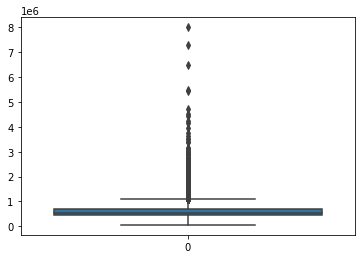

In [6]:
ax = sns.boxplot(raw_sales['price']);

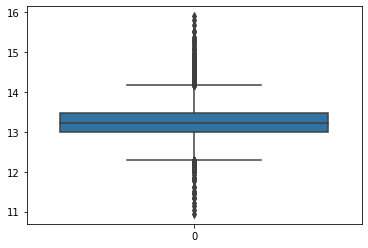

In [7]:
raw_sales['price_trans'] = np.log(raw_sales['price'])

ax = sns.boxplot(raw_sales['price_trans']);

### Exploratory Data Analysis

In [8]:
raw_sales.describe()

,postcode,price,propertyType,bedrooms,week,week_day,month,season,year,price_trans
count,29550.000000,2.955000e+04,29550.000000,29550.000000,29550.0,29550.000000,29550.000000,29550.000000,29550.000000,29550.000000
mean,2730.323621,6.098047e+05,0.169780,3.253469,27.485076,2.612047,6.715025,1.558308,2014.624907,13.244892
std,146.729215,2.817045e+05,0.375446,0.946101,14.683864,1.709251,3.379598,1.120435,2.964912,0.374879
min,2600.000000,5.650000e+04,0.000000,1.000000,1.0,0.000000,1.000000,0.000000,2007.000000,10.941996
25%,2607.000000,4.400000e+05,0.000000,3.000000,14.0,1.000000,4.000000,1.000000,2013.000000,12.994530
50%,2615.000000,5.500000e+05,0.000000,3.000000,27.0,3.000000,7.000000,2.000000,2015.000000,13.217674
75%,2905.000000,7.050000e+05,0.000000,4.000000,41.0,4.000000,10.000000,3.000000,2017.000000,13.465953
max,2914.000000,8.000000e+06,1.000000,5.000000,53.0,6.000000,12.000000,3.000000,2019.000000,15.894952


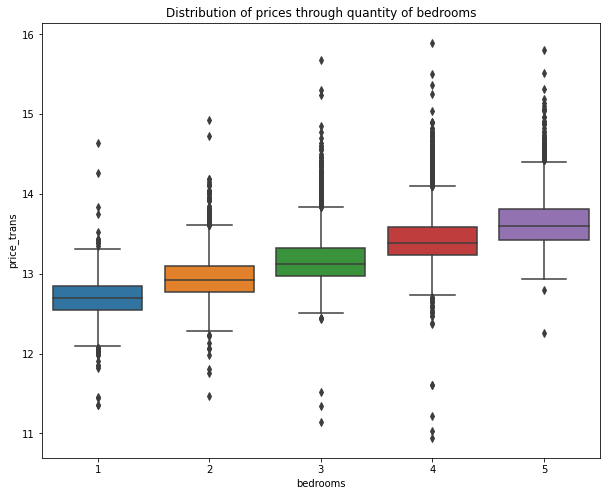

In [9]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(x = 'bedrooms', y = 'price_trans', data = raw_sales)
ax.set_title('Distribution of prices through quantity of bedrooms');

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\395435257.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mean = raw_sales.groupby('year').mean().reset_index()


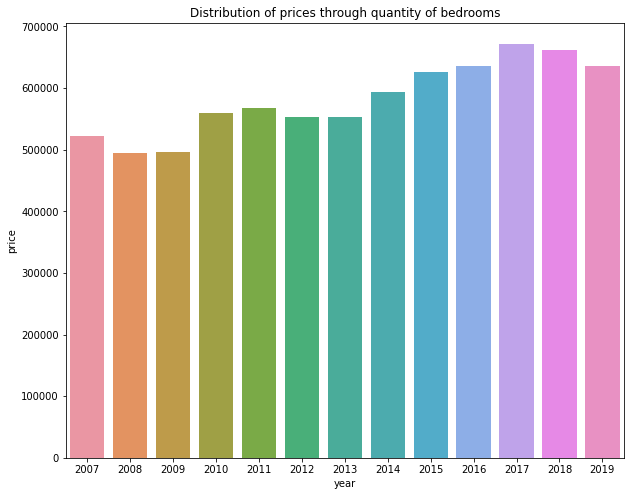

In [10]:
plt.figure(figsize=(10,8))
year_mean = raw_sales.groupby('year').mean().reset_index()
ax = sns.barplot(x = 'year', y = 'price', data = year_mean)
ax.set_title('Distribution of prices through quantity of bedrooms');

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\1312415078.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  month_mean = raw_sales.groupby('month').mean().reset_index()


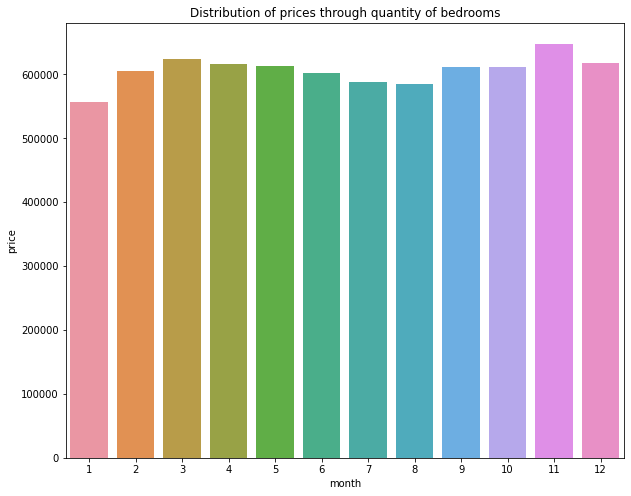

In [11]:
plt.figure(figsize=(10,8))
month_mean = raw_sales.groupby('month').mean().reset_index()
ax = sns.barplot(x = 'month', y = 'price', data = month_mean)
ax.set_title('Distribution of prices through quantity of bedrooms');

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\2463895743.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  week_mean = raw_sales.groupby('week').mean().reset_index()


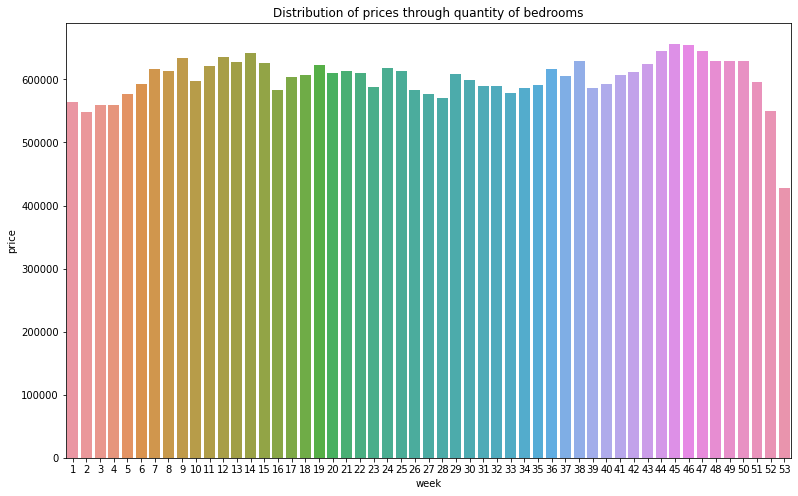

In [12]:
plt.figure(figsize=(13,8))
week_mean = raw_sales.groupby('week').mean().reset_index()
ax = sns.barplot(x = 'week', y = 'price', data = week_mean)
ax.set_title('Distribution of prices through quantity of bedrooms');

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\1697468250.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  week_day_mean = raw_sales.groupby('week_day').mean().reset_index()


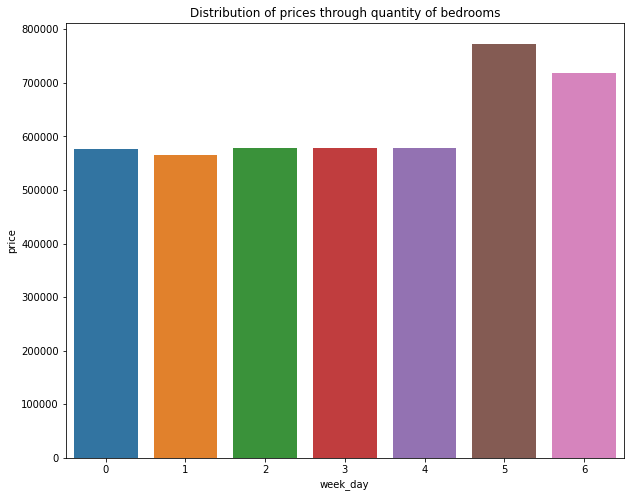

In [13]:
plt.figure(figsize=(10,8))
week_day_mean = raw_sales.groupby('week_day').mean().reset_index()
ax = sns.barplot(x = 'week_day', y = 'price', data = week_day_mean)
ax.set_title('Distribution of prices through quantity of bedrooms');

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\2512939209.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  season_mean = raw_sales.groupby('season').mean().reset_index()


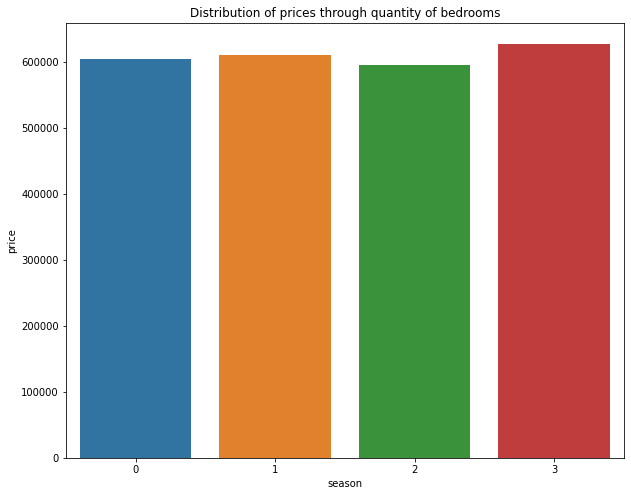

In [14]:
plt.figure(figsize=(10,8))
season_mean = raw_sales.groupby('season').mean().reset_index()
ax = sns.barplot(x = 'season', y = 'price', data = season_mean)
ax.set_title('Distribution of prices through quantity of bedrooms');

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\1407085352.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.barplot(x = 'price_trans', y= 'index' , data = raw_sales.corr()['price_trans'].reset_index().sort_values(ascending=False, by = 'price_trans'));


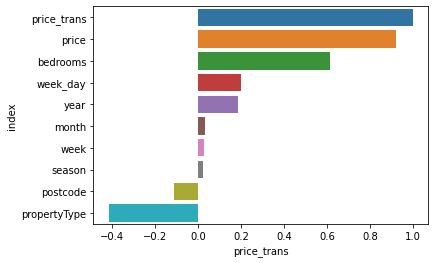

In [15]:
sns.barplot(x = 'price_trans', y= 'index' , data = raw_sales.corr()['price_trans'].reset_index().sort_values(ascending=False, by = 'price_trans'));

## Separing data in training and testing data

In [17]:
raw_sales

,datesold,postcode,price,propertyType,bedrooms,week,week_day,month,season,year,price_trans
0,2007-02-07,2607,525000,0,4,6,2,2,0,2007,13.171154
1,2007-02-27,2906,290000,0,3,9,1,2,0,2007,12.577636
2,2007-03-07,2905,328000,0,3,10,2,3,0,2007,12.700769
3,2007-03-09,2905,380000,0,4,10,4,3,0,2007,12.847927
4,2007-03-21,2906,310000,0,3,12,2,3,0,2007,12.644328
...,...,...,...,...,...,...,...,...,...,...,...
29575,2019-07-25,2900,500000,1,3,30,3,7,2,2019,13.122363
29576,2019-07-25,2612,560000,1,2,30,3,7,2,2019,13.235692
29577,2019-07-26,2912,464950,1,2,30,4,7,2,2019,13.049685
29578,2019-07-26,2601,589000,1,2,30,4,7,2,2019,13.286181


In [29]:
x = raw_sales.drop(['price', 'price_trans', 'datesold'], axis = 1)
y = raw_sales['price_trans']
x.week = x.week.astype(int)
test_size = 0.2
data_size = len(x)
x_train = x[:(int(data_size * (1-test_size)))]
x_test = x[(int(data_size * (1-test_size))):]
y_train = y[:(int(data_size * (1-test_size)))]
y_test = y[(int(data_size * (1-test_size))):]

C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\2724373008.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = y[:(int(data_size * (1-test_size)))]
C:\Users\bitun\AppData\Local\Temp\ipykernel_14368\2724373008.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test = y[(int(data_size * (1-test_size))):]


## Creating model and training

In [30]:
x_train.dtypes

postcode        int64
propertyType    int64
bedrooms        int64
week            int32
week_day        int64
month           int64
season          int64
year            int64
dtype: object

In [31]:
from xgboost import XGBRegressor

#params = {'learning_rate': 0.17487160702725146, 'loss': 'absolute_error', 'max_depth': 5, 'min_impurity_decrease': 0.9282174709047137, 'min_samples_leaf': 65, 
#          'min_samples_split': 33, 'n_estimators': 50, 'subsample': 0.7067241710796682}

rfr = XGBRegressor(n_estimators=15000,
                       early_stopping_rounds=50,
                       learning_rate=0.01)
rfr.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

y_pred = rfr.predict(x_test)

[0]	validation_0-rmse:12.68765	validation_1-rmse:12.35780
[100]	validation_0-rmse:4.65051	validation_1-rmse:4.35252
[200]	validation_0-rmse:1.71392	validation_1-rmse:1.52510
[300]	validation_0-rmse:0.65211	validation_1-rmse:0.53850
[400]	validation_0-rmse:0.29183	validation_1-rmse:0.26368
[500]	validation_0-rmse:0.19531	validation_1-rmse:0.25242
[501]	validation_0-rmse:0.19492	validation_1-rmse:0.25255


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = rfr.score(x_test, y_test)

print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("MAPE: %.2f" % (mape * 100) + '%')

R²: 0.56
MSE: 0.06
RMSE: 0.25
MAPE: 1.45%


## Evaluating the model

In [40]:
test = raw_sales.iloc[(int(data_size * (1-test_size))):].copy()
test['predictions'] = rfr.predict(x_test)
test['price_prediction'] = np.exp(test['predictions'])
test['error'] = abs(test['price'] - test['price_prediction'])
test['%err'] = abs((test['price_prediction'] / test['price']) - 1)
test.head()

,datesold,postcode,price,propertyType,bedrooms,week,week_day,month,season,year,price_trans,predictions,price_prediction,error,%err
23659,2019-02-07,2905,790000,0,4,6,3,2,0,2019,13.579788,13.267510,578104.81250,211895.18750,0.268222
23660,2019-02-07,2602,850000,0,4,6,3,2,0,2019,13.652992,13.645295,843483.06250,6516.93750,0.007667
23661,2019-02-08,2615,515000,0,3,6,4,2,0,2019,13.151922,13.037857,459482.90625,55517.09375,0.107800
23662,2019-02-08,2913,525000,0,3,6,4,2,0,2019,13.171154,13.057533,468613.34375,56386.65625,0.107403
23663,2019-02-08,2906,725000,0,5,6,4,2,0,2019,13.493927,13.391140,654181.43750,70818.56250,0.097681


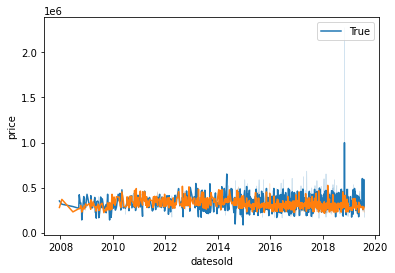

In [45]:
sns.lineplot(x = 'datesold', y = 'price', data = test.loc[test['bedrooms'] == 1])
sns.lineplot(x = 'datesold', y = 'price_prediction', data = test.loc[test['bedrooms'] == 1])
plt.legend(['True'])

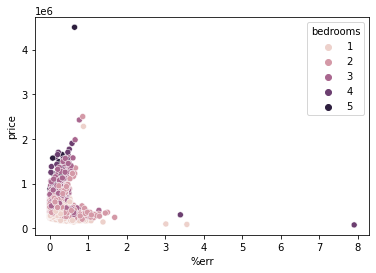

In [44]:
sns.scatterplot(x = '%err', y = 'price', data = test, hue = 'bedrooms');

## Hiperparameter tuning

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [84]:
parameters = {
        'loss': ['squared_error', 'absolute_error'],
        'learning_rate': sp_randFloat(),
        'subsample'    : sp_randFloat(),
        'n_estimators' : sp_randInt(100, 1000),
        'max_depth'    : sp_randInt(4, 10),
        "n_estimators":[5,50,250,500],
        'min_impurity_decrease': sp_randFloat(),
        'min_samples_leaf': sp_randInt(5,100),
        'min_samples_split': sp_randInt(5,100)
}

In [48]:
#randm_src = RandomizedSearchCV(estimator=rfr, param_distributions = parameters,
#                               cv = 2, n_iter = 10, n_jobs=-1)
#randm_src.fit(train_x, train_y)

#print(" Results from Random Search " )
#print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
#print("\n The best score across ALL searched params:\n", randm_src.best_score_)
#print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

In [203]:
randm_src.best_estimator_.score(test_x, test_y)

0.6570856852128106